Epoch 1/15
1250/1250 - 3s - loss: 2.4184 - accuracy: 0.2584 - val_loss: 2.2984 - val_accuracy: 0.2936
Epoch 2/15
1250/1250 - 3s - loss: 2.2451 - accuracy: 0.3115 - val_loss: 2.2430 - val_accuracy: 0.3123
Epoch 3/15
1250/1250 - 3s - loss: 2.1755 - accuracy: 0.3302 - val_loss: 2.2245 - val_accuracy: 0.3194
Epoch 4/15
1250/1250 - 3s - loss: 2.1264 - accuracy: 0.3428 - val_loss: 2.2485 - val_accuracy: 0.3159
Epoch 5/15
1250/1250 - 3s - loss: 2.0831 - accuracy: 0.3548 - val_loss: 2.1831 - val_accuracy: 0.3281
Epoch 6/15
1250/1250 - 3s - loss: 2.0427 - accuracy: 0.3657 - val_loss: 2.1934 - val_accuracy: 0.3290
Epoch 7/15
1250/1250 - 2s - loss: 2.0117 - accuracy: 0.3736 - val_loss: 2.2179 - val_accuracy: 0.3337
Epoch 8/15
1250/1250 - 2s - loss: 1.9796 - accuracy: 0.3802 - val_loss: 2.2079 - val_accuracy: 0.3292
Epoch 9/15
1250/1250 - 2s - loss: 1.9465 - accuracy: 0.3915 - val_loss: 2.2264 - val_accuracy: 0.3290
Epoch 10/15
1250/1250 - 2s - loss: 1.9171 - accuracy: 0.4014 - val_loss: 2.2472 - 

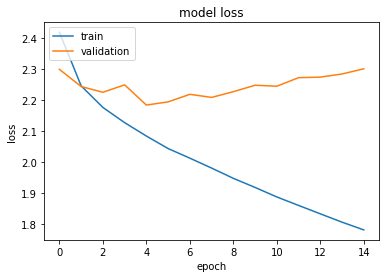

['loss', 'accuracy']
[2.3271753787994385, 0.3269999921321869]


In [32]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical  

(training_data, training_labels), (testing_data, testing_labels) = (cifar100.load_data("coarse"))

def centre_data(train, test):
    
    # calculate the means for each attribute of the training data
    column_means = np.mean(train, axis=0) 
    
    # centre training data by subtracting training data attribute means
    for i in range(len(train)):
        train[i] = train[i] - column_means
    
    # centre testing data by subtracting training data attribute means
    for x in range(len(test)):
        test[x] = test[x] - column_means
        
    return train, test

# apply PCA on the data 
def PCA(variance_target, training_data, testing_data):

    U, sigma, Vt = np.linalg.svd(training_data, full_matrices=False)
    
    sum_square_singular = np.sum(sigma**2)
    
    ratios = sigma**2/sum_square_singular
                
    n_components = 0
    explained_variance = 0
    
    # determine how many principle components must be retained to maintain the target level of explained variance
    for i in range(len(ratios)):
        if explained_variance >= variance_target:
            break
        else: 
            n_components += 1
            explained_variance += ratios[i]
    
    return training_data.dot(Vt.T[:, :n_components]), testing_data.dot(Vt.T[:, :n_components])

    
training_labels = to_categorical(training_labels, 20)
testing_labels = to_categorical(testing_labels, 20)

# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)

training_data = np.reshape(training_data,(50000, 3072))
testing_data = np.reshape(testing_data,(10000, 3072))

training_data = training_data.astype('float32')
testing_data = testing_data.astype('float32')

training_data, testing_data = centre_data(training_data, testing_data)

training_data, testing_data = PCA(0.8, training_data, testing_data)

# Normalization of pixel values (to [0-1] range)

training_data /= 255
testing_data /= 255

model = Sequential()

model.add(Dense(256, activation='relu', input_dim=training_data.shape[1]))

model.add(Dense(256, activation='relu'))

model.add(Dense(20, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(training_data, training_labels, epochs=15, batch_size=32, verbose=2, validation_split=0.2)

def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
plotLosses(history)

score = model.evaluate(testing_data, testing_labels, batch_size=128, verbose=0)

print(model.metrics_names)
print(score)